In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [5]:
from surprise import dump
_, nmf = dump.load(PROCESSED/'Extra_IsinBuySell_NMF.dump')

In [6]:
from src.utils import get_weeks
week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [7]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'all_weeks/week_{name}_diffscount.feather'))

CPU times: user 844 ms, sys: 436 ms, total: 1.28 s
Wall time: 1.28 s


## NMF features

In [9]:
uid = nmf.trainset._raw2inner_id_users
iid = nmf.trainset._raw2inner_id_items

In [11]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
for w in weeks:
    w['NMF_CustomerBias'] = [nmf.bu[uid[x]] for x in w.CustomerIdx]
    w['NMF_IsinBuySellBias'] = [nmf.bi[iid[f'{iIdx}-{bIdx}']] \
                                for iIdx, bIdx in zip(w.IsinIdx, w.BuySell)]
    w['NMF_Recommend'] = [nmf.predict(cIdx, f'{iIdx}-{bIdx}').est \
                          for cIdx, iIdx, bIdx in zip(w.CustomerIdx, w.IsinIdx, w.BuySell)]

CPU times: user 52.3 s, sys: 620 ms, total: 52.9 s
Wall time: 52.8 s


In [14]:
%%time
for n, w in zip(week_labels, weeks):
    customer_factors = np.array([nmf.pu[uid[cIdx]] for cIdx in w.CustomerIdx])
    isin_factors = np.array([nmf.qi[iid[f'{iIdx}-{bIdx}']] \
                             for iIdx, bIdx in zip(w.IsinIdx, w.BuySell)])
    for i in range(customer_factors.shape[1]):
        w[f'NMF_CustomerFactor{i:02}'] = customer_factors[:,i]
    for i in range(isin_factors.shape[1]):
        w[f'NMF_IsinBuySellFactor{i:02}'] = isin_factors[:,i]

CPU times: user 15.5 s, sys: 1.41 s, total: 17 s
Wall time: 16.9 s


## Extra Features

In [16]:
%%time
for w in weeks:
    w['Month'] = w.TradeDateKey.apply(lambda x: x // 10**4 % 10**2)
    w['Day'] = w.TradeDateKey.apply(lambda x: x % 10**2)

CPU times: user 4.27 s, sys: 156 ms, total: 4.43 s
Wall time: 4.42 s


In [18]:
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [19]:
%%time
from src.utils import preprocessing_pipeline
for i, w in enumerate(weeks):
    weeks[i] = preprocessing_pipeline(w, customer, isin, trade)

CPU times: user 7.07 s, sys: 1.06 s, total: 8.13 s
Wall time: 8.12 s


## Preprocessing

In [21]:
from functools import cmp_to_key
from src.utils import composite_rating_cmp
ratings = list(isin.CompositeRating.value_counts().index)
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [22]:
%%time
for w in weeks:
    w['CompositeRating']  = w.CompositeRating.apply(lambda x: rank[x])

CPU times: user 2.4 s, sys: 228 ms, total: 2.63 s
Wall time: 2.63 s


In [23]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [24]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [25]:
%%time
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

CPU times: user 6.27 s, sys: 220 ms, total: 6.49 s
Wall time: 6.48 s


## Model

In [26]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [27]:
all_2018 = pd.concat(weeks[:-1])

In [28]:
all_2018.TradeDateKey.unique()

array([20180101, 20180108, 20180115, 20180122, 20180129, 20180205,
       20180212, 20180219, 20180226, 20180305, 20180312, 20180319,
       20180326, 20180402, 20180409, 20180416])

In [35]:
for i in range(-8,-1):
    train, val = pd.concat(weeks[:i]), weeks[i]
    print(train['TradeDateKey'].min(), train['TradeDateKey'].max(),
          val['TradeDateKey'].unique())

20180101 20180226 [20180305]
20180101 20180305 [20180312]
20180101 20180312 [20180319]
20180101 20180319 [20180326]
20180101 20180326 [20180402]
20180101 20180402 [20180409]
20180101 20180409 [20180416]


In [36]:
%%time
results = None
output = []
for i in range(-8,-1): 
    train, val = pd.concat(weeks[:i]), weeks[i]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
            
    _, _, results, model = run_model(
            LGBMClassifier(n_estimators=400),
            X_train, y_train, X_val, y_val, None,
            metric_names, results, 
            params_desc='n_estimators=400',
            dataset_desc=f'{week_labels[i]}_NMF_diffcounts', 
            early_stopping_rounds=30)
    output.append(model)

LGBMClassifier 

[1]	valid_0's auc: 0.700726
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.701053
[3]	valid_0's auc: 0.709124
[4]	valid_0's auc: 0.714386
[5]	valid_0's auc: 0.715442
[6]	valid_0's auc: 0.714937
[7]	valid_0's auc: 0.71719
[8]	valid_0's auc: 0.717143
[9]	valid_0's auc: 0.71773
[10]	valid_0's auc: 0.718638
[11]	valid_0's auc: 0.720363
[12]	valid_0's auc: 0.720713
[13]	valid_0's auc: 0.722214
[14]	valid_0's auc: 0.722513
[15]	valid_0's auc: 0.723284
[16]	valid_0's auc: 0.723001
[17]	valid_0's auc: 0.723509
[18]	valid_0's auc: 0.724232
[19]	valid_0's auc: 0.725583
[20]	valid_0's auc: 0.726288
[21]	valid_0's auc: 0.726943
[22]	valid_0's auc: 0.726651
[23]	valid_0's auc: 0.728667
[24]	valid_0's auc: 0.728344
[25]	valid_0's auc: 0.729715
[26]	valid_0's auc: 0.729932
[27]	valid_0's auc: 0.729817
[28]	valid_0's auc: 0.730296
[29]	valid_0's auc: 0.730863
[30]	valid_0's auc: 0.731077
[31]	valid_0's auc: 0.733157
[32]	valid_0's auc: 0.733421
[33]

In [41]:
results['round'] = [117, 388, 245, 237, 43, 43, 165]

In [42]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean,round
0,20180305_NMF_diffcounts,LGBMClassifier,n_estimators=400,75.98,0.781129,0.740081,117
1,20180312_NMF_diffcounts,LGBMClassifier,n_estimators=400,163.14,0.809800,0.768491,388
2,20180319_NMF_diffcounts,LGBMClassifier,n_estimators=400,134.11,0.799975,0.804309,245
3,20180326_NMF_diffcounts,LGBMClassifier,n_estimators=400,149.33,0.801690,0.797883,237
4,20180402_NMF_diffcounts,LGBMClassifier,n_estimators=400,72.28,0.765397,0.799299,43
5,20180409_NMF_diffcounts,LGBMClassifier,n_estimators=400,74.92,0.770242,0.830529,43
6,20180416_NMF_diffcounts,LGBMClassifier,n_estimators=400,147.72,0.805877,0.865081,165


In [46]:
np.mean(results['round']), np.median(results['round'])

(176.85714285714286, 165.0)

## Train all dataset (2018)

In [47]:
all_2018 = pd.concat(weeks[:-1])

In [49]:
all_2018.TradeDateKey.unique()

array([20180101, 20180108, 20180115, 20180122, 20180129, 20180205,
       20180212, 20180219, 20180226, 20180305, 20180312, 20180319,
       20180326, 20180402, 20180409, 20180416])

In [50]:
%%time
train = all_2018
test = weeks[-1]
X_train, y_train = train.drop(id_cols + [target_col], axis=1), train[target_col]
X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
assert list(X_train.columns) == list(X_test.columns)
y_test, _, train_res, model = run_model(
            LGBMClassifier(n_estimators=170),
            X_train, y_train, None, None, X_test,
            metric_names, None, 
            params_desc='n_estimators=170',
            dataset_desc=f'all_2018_NMF_diffcounts', 
            early_stopping_rounds=None)

LGBMClassifier 

{'auc': {'trn': [0.8119546378310276], 'val': [0]}}

{'trn_auc_mean': 0.8119546378310276, 'val_auc_mean': 0.0}
CPU times: user 11min 17s, sys: 13 s, total: 11min 30s
Wall time: 2min 23s


In [51]:
train_res

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,all_2018_NMF_diffcounts,LGBMClassifier,n_estimators=170,138.79,0.811955,0.0


In [52]:
test[target_col] = y_test

## Submission

In [53]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [54]:
submission[target_col].describe()

count    484758.000000
mean          0.026873
std           0.041772
min           0.000876
25%           0.008036
50%           0.015009
75%           0.028979
max           0.915477
Name: CustomerInterest, dtype: float64

In [55]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.016014
1,c2cc6cc2a8,0.052203
2,a8e94f6344,0.006195
3,758bae1e35,0.002845
4,02ab378ee8,0.009119


In [56]:
submission.to_csv(SUBMISSIONS/'RA01-20-lgbm_2018_MF_diffscounts_0101-0416.csv', index=False)

## Feature importance

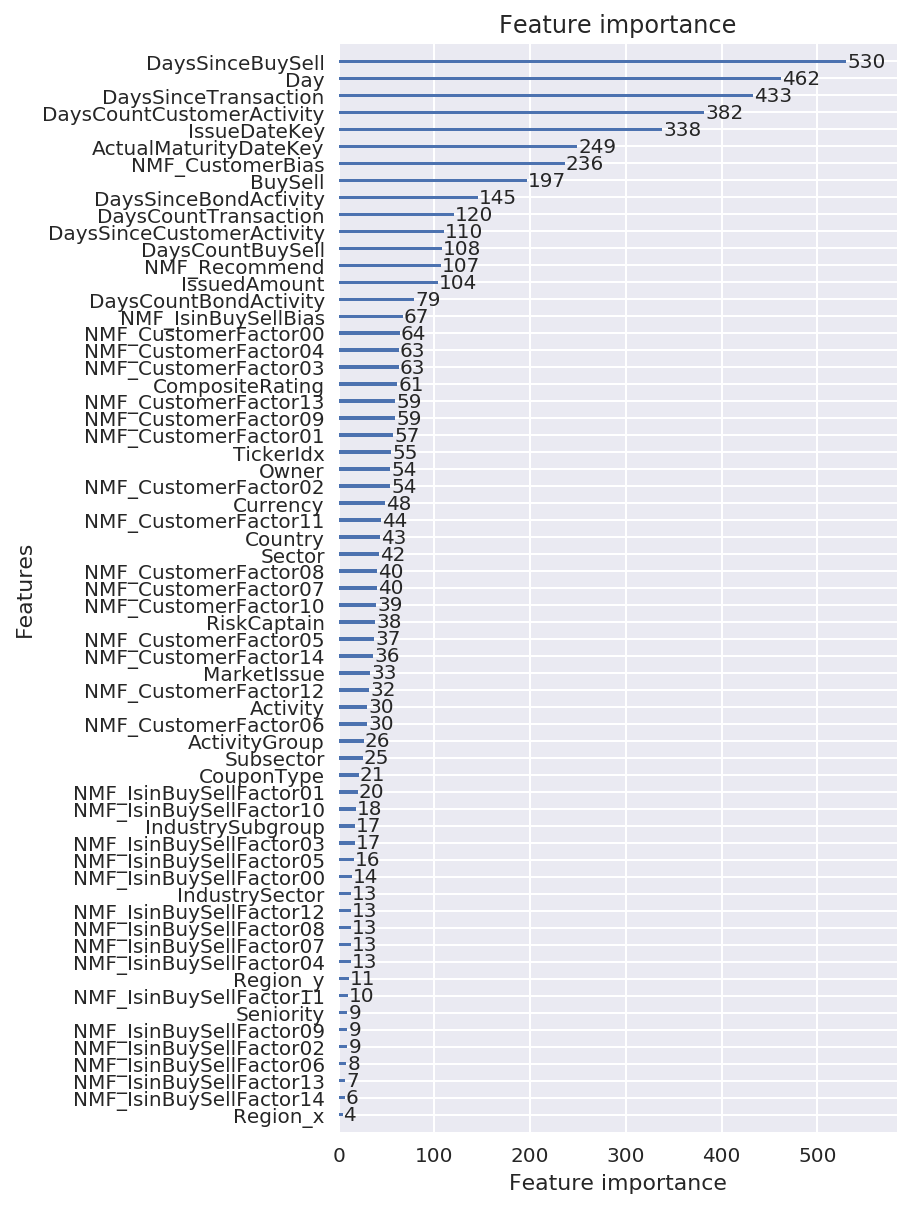

In [58]:
from lightgbm import plot_importance
plot_importance(model, figsize=(5,10))